# ECG Heartbeat Classification using Neural Networks

## I. Introduction

![ecg.jpg](picture\ecg.jpg)

Electrocardiography is the process of producing an electrocardiogram (ECG or EKG), a recording – a graph of voltage versus time – of the electrical activity of the heart using electrodes placed on the skin. ECG is a very important and significant tool in heart disease diagnoses.

Changes in the normal ECG pattern occur in numerous cardiac abnormalities, including cardiac rhythm disturbances (such as atrial fibrillation and ventricular tachycardia), inadequate coronary artery blood flow (such as myocardial ischemia and myocardial infarction), and electrolyte disturbances (such as hypokalemia and hyperkalemia).

In this project, I want to classify different arrhytmia types on ECG. 
The [MIT-BIH Arrhythmia Database](https://physionet.org/content/mitdb/1.0.0/) contains 48 half-hour excerpts of two-channel ambulatory ECG recordings, obtained from 47 subjects studied by the BIH Arrhythmia Laboratory between 1975 and 1979. Twenty-three recordings were chosen at random from a set of 4000 24-hour ambulatory ECG recordings collected from a mixed population of inpatients (about 60%) and outpatients (about 40%) at Boston's Beth Israel Hospital; the remaining 25 recordings were selected from the same set to include less common but clinically significant arrhythmias that would not be well-represented in a small random sample.

Arrhythmia Dataset

    Number of Samples: 109446
    Number of Categories: 5
    Sampling Frequency: 125Hz
    Data Source: Physionet's MIT-BIH Arrhythmia Dataset
    Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]

- N : Non-ecotic beats (normal beat)
- S : Supraventricular ectopic beats
- V : Ventricular ectopic beats
- F : Fusion Beats
- Q : Unknown Beats

*Remark: These signals are preprocessed and segmented, with each segment corresponding to a heartbeat. All the samples are cropped, downsampled and padded with zeroes if necessary to the fixed dimension of 188.*

## II. Data preparation

In [1]:
# import packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight
import warnings
warnings.filterwarnings('ignore')

# load data
train_df=pd.read_csv('mitbih_train.csv',header=None)
test_df=pd.read_csv('mitbih_test.csv',header=None)

train_df.head()

Using TensorFlow backend.


,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [2]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87554 entries, 0 to 87553
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 125.6 MB


In [3]:
train_df[187]=train_df[187].astype(int)
train_df[187].value_counts()

0    72471
4     6431
2     5788
1     2223
3      641
Name: 187, dtype: int64

We can see these samples are not balanced here. Most of them are type '0', which is the normal beat. And Fusion Beats are least. So we resample them next, and get a dataset including 100,000 samples where each category has 20,000 samples respectively.

In [4]:
from sklearn.utils import resample
df_1=train_df[train_df[187]==1]
df_2=train_df[train_df[187]==2]
df_3=train_df[train_df[187]==3]
df_4=train_df[train_df[187]==4]
df_0=(train_df[train_df[187]==0]).sample(n=20000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=20000,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=20000,random_state=124)
df_3_upsample=resample(df_3,replace=True,n_samples=20000,random_state=125)
df_4_upsample=resample(df_4,replace=True,n_samples=20000,random_state=126)

train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

To realize different ECG types better, I randomly draw 1 sample from each category to see if there are any difference.

In [5]:
c=train_df.groupby(187,group_keys=False).apply(lambda train_df : train_df.sample(1))
c

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
63604,1.000000,0.723982,0.351433,0.061840,0.000000,0.110106,0.138763,0.105581,0.095023,0.099548,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0
72782,0.956349,0.853175,0.218254,0.000000,0.079365,0.119048,0.099206,0.138889,0.158730,0.134921,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1
75197,0.488136,0.457627,0.308475,0.016949,0.000000,0.081356,0.067797,0.067797,0.050847,0.054237,...,0.345763,0.359322,0.376271,0.40678,0.430508,0.477966,0.501695,0.518644,0.505085,2
81022,1.000000,0.765957,0.451368,0.145897,0.045593,0.085106,0.063830,0.045593,0.037994,0.025836,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,3
83337,0.518841,0.420290,0.376812,0.376812,0.342029,0.333333,0.286957,0.260870,0.205797,0.107246,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,4


Firstly, let's draw a plot of the normal beat, which is type '0' here. It just looks like the normal ECG that we saw before.

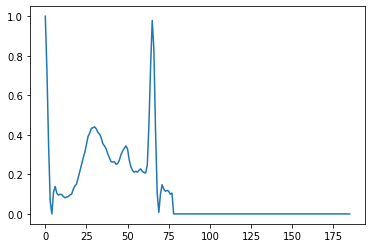

In [6]:
 plt.plot(c.iloc[0,:186])

Then I draw the other 4 types ECG which are abnormal below.

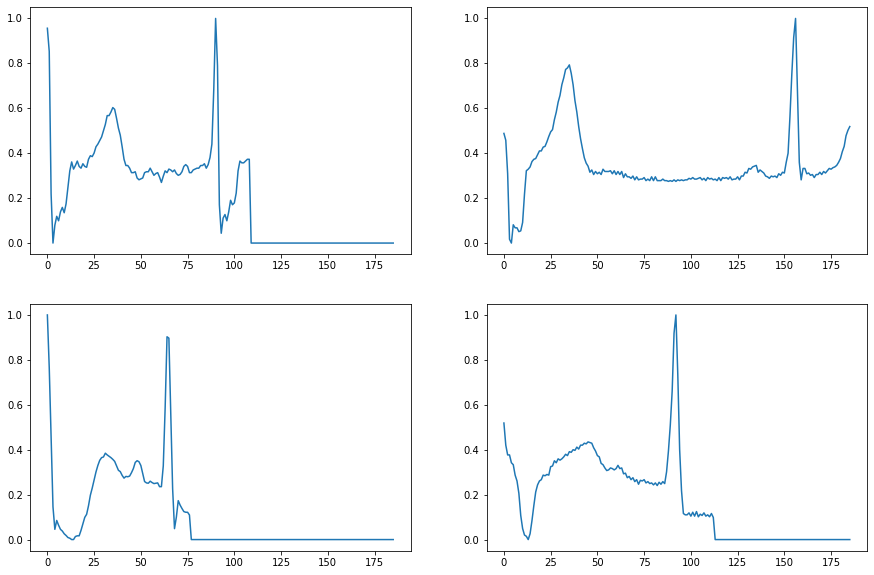

In [7]:
f, axes = plt.subplots(2, 2, sharex=False, sharey=False) 
f.set_figheight(10)
f.set_figwidth(15)
axes[0,0].plot(c.iloc[1,:186])
axes[0,1].plot(c.iloc[2,:186])
axes[1,0].plot(c.iloc[3,:186])
axes[1,1].plot(c.iloc[4,:186])

Indeedly they looks not regular. Actually I am not the expert in ECG so it difficult for me to distinguish them. Here is some reference for these abnormal types:

**Supraventricular ectopic beats:**
![Supraventricular ectopic beats.png](picture\Supraventricular-ectopic-beats.png)

**Ventricular ectopic beats:**
![Ventricular ectopic beats](picture\Ventricular-ectopic-beats.png)

**Fusion Beats:**
![Fusion Beats](picture\Fusion-Beats.png)

## III. Modeling

Now let's bulid a Neural Networks model to classfy the ECG.

In [8]:
target_train=train_df[187]
target_test=test_df[187]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)
X_train=train_df.iloc[:,:186].values
X_test=test_df.iloc[:,:186].values
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

In [9]:
def network(X_train,y_train,X_test,y_test):
    

    im_shape=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    conv1_1=Convolution1D(64, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)
    pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
    conv2_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)
    pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)
    conv3_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool2)
    conv3_1=BatchNormalization()(conv3_1)
    pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
    flatten=Flatten()(pool3)
    dense_end1 = Dense(64, activation='relu')(flatten)
    dense_end2 = Dense(32, activation='relu')(dense_end1)
    main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)
    
    
    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
    
    
    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

    history=model.fit(X_train, y_train,epochs=20,callbacks=callbacks, batch_size=32,validation_data=(X_test,y_test))
    model.load_weights('best_model.h5')
    return(model,history)

In [10]:
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from keras.layers.normalization import BatchNormalization
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint

model,history=network(X_train,y_train,X_test,y_test)

Train on 100000 samples, validate on 21892 samples
Epoch 1/20
100000/100000 [==============================] - 161s 2ms/step - loss: 0.2038 - accuracy: 0.9274 - val_loss: 0.1718 - val_accuracy: 0.9409
Epoch 2/20
100000/100000 [==============================] - 165s 2ms/step - loss: 0.0797 - accuracy: 0.9727 - val_loss: 0.3312 - val_accuracy: 0.8733
Epoch 3/20
100000/100000 [==============================] - 166s 2ms/step - loss: 0.0542 - accuracy: 0.9814 - val_loss: 0.1461 - val_accuracy: 0.9567
Epoch 4/20
100000/100000 [==============================] - 171s 2ms/step - loss: 0.0411 - accuracy: 0.9864 - val_loss: 0.1411 - val_accuracy: 0.9609
Epoch 5/20
100000/100000 [==============================] - 167s 2ms/step - loss: 0.0322 - accuracy: 0.9898 - val_loss: 0.1488 - val_accuracy: 0.9629
Epoch 6/20
100000/100000 [==============================] - 166s 2ms/step - loss: 0.0276 - accuracy: 0.9913 - val_loss: 0.1407 - val_accuracy: 0.9656
Epoch 7/20
100000/100000 [=======================

In [11]:
model.evaluate((X_test),y_test, verbose=0)[1]

0.9717705249786377

As we can see, the accuracy rate exceed 97%, which is an excellent result for this model.